In [1]:
from cv2 import imread, imwrite
from pyFusion.fusion import *
from pyFusion.legacy.image_fusion_tool import Image_fusion_tool
from pyFusion.models.vgg19 import VGG19
from pyFusion.models.vgg16 import VGG16
from pyFusion.models.squeezeNet import Squeeze
from pyFusion import metrics
from torch import device
from torch.cuda import is_available

import matplotlib.pyplot as plt


In [2]:
#images = ['images/MRI-CT/ct1.png', 'images/MRI-CT/mri.png']
#output = 'results/MRI-CT/'
#images = ['images/MRI-PET/dg.png', 'images/MRI-PET/mr.png']
#output = 'results/MRI-PET/'
#images = ['images/MRI-SPECT/tc.png', 'images/MRI-SPECT/mr1.png']
#output = 'results/MRI-SPECT/'
images = ['images/T1-T2/t1.png', 'images/T1-T2/t2.png']
output = 'results/T1-T2/'

# Read images
input_images = []
for image in images:
    input_images.append(imread(image))

In [3]:

device = device("cuda" if is_available() else "cpu")
#model = VGG19(device)
#model = VGG16(device)
model = Squeeze(device)

FU = Fusion(input_images, model)
fused_image = FU.fuse()


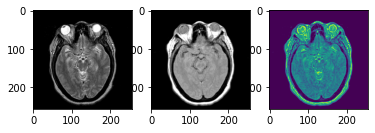

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.imshow(input_images[0])
ax2.imshow(input_images[1])
ax3.imshow(fused_image)

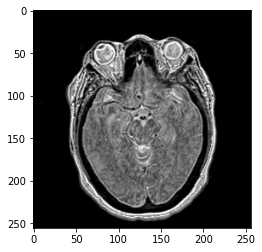

In [5]:
#imwrite("fusion", fused_image.astype('uint8'))
plt.imshow(fused_image, cmap='gray')

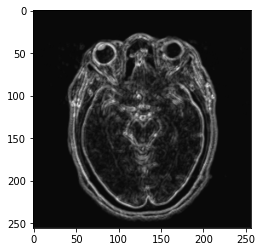

In [6]:
plt.imshow(FU.features[0][0], cmap='gray')

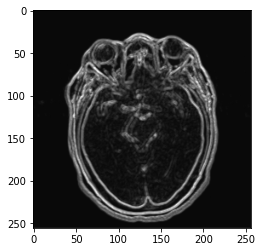

In [7]:
plt.imshow(FU.features[0][1], cmap='gray')

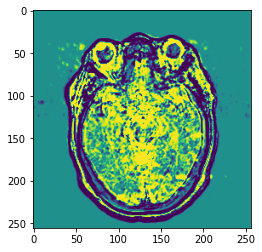

In [8]:
plt.imshow(FU.weights[0][0])

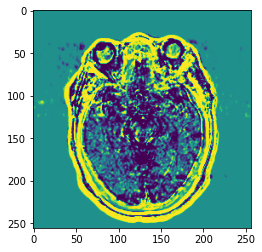

In [9]:
plt.imshow(FU.weights[0][1])

In [10]:
FU.images_to_tensors[0].shape[2:]

torch.Size([256, 256])

In [11]:
from cv2 import imread
from pyFusion.fusion import *
from pyFusion.iqa import metrics
from pyFusion.iqa import xideasPetrovic as xp

import matplotlib.pyplot as plt

In [12]:
# Read images

#images_path = ['images/MRI-CT/ct.png', 'images/MRI-CT/mr.png']
images_path = ['images/MRI-PET/dg.png', 'images/MRI-PET/mr.png']
#images_path = ['images/MRI-SPECT/dg.png', 'images/MRI-SPECT/tc.png']
#images_path = ['images/T1-T2/t1.png', 'images/T1-T2/t2.png']

output = 'results/MRI-PET'
#output = 'results/MRI-CT'
#output='results/T1-T2/'
images = []
for image in images_path:
    images.append(imread(image))
im0 = images[0]
im1 = images[1]

In [13]:
fused_image = imread('results/MRI-PET/squeeze.png')
#fused_image = imread('results/MRI-CT/squeeze.png')

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import *
from random import *
from PIL import Image
from sklearn.decomposition import PCA
from pyFusion.legacy.basic_cv_tool import *

class Image_fusion_tool:
    
    def __init__(self, ImageName):
        self.ImageName = ImageName
    
    def weighted_average_fusion(self, im0, im1, w1, w2):
        '''
        This is the simplest image fusion algorithm. 
        :param im0: The first origin image.
        :param im1: The second origin image.
        :param w1: The weight of first image.
        :param w2: The weight of second image.
        :return: The fusioned image.
        '''
        if w1<0 or w2<0:
            print('invalid weight value')
            return
        elif w1 + w2 != 1:
            w1 = w1/(w1+w2)
            w2 = w2/(w1+w2)
        shape = np.shape(im0)
        img = np.zeros(shape,dtype = np.int8)
        if np.shape(im1) != shape:
            im1 = cv2.resize(img2, np.shape(im0), interpolation = cv2.INTER_CUBIC)
        img = w1*im0+w2*im1
        return img
    
    def PCA_image_fusion(self, im0, im1):
        '''
        This is the algorithm of image fusion based on PCA.
        :param im0: The origin image.
        :param im1: The high resolution image.
        :return: The fusioned image.
        '''
        estimator = PCA()
        estimator.fit(im0.copy())
        estimator.fit(im1.copy())
        img_f1 = estimator.transform(im0.copy())
        img_f2 = estimator.transform(im1.copy())
        img_f1[:,:40] = img_f2[:,:40]
        img = estimator.inverse_transform(img_f1)
        return img

    def PCA_fusion(self, im0, im1):
        imageSize = im0.size
        # Todo: for more than two images
        allImage = np.concatenate((im0.reshape(1, imageSize), im1.reshape(1, imageSize)), axis=0)
        covImage = np.cov(allImage)
        D, V = np.linalg.eig(covImage)
        if D[0] > D[1]:
            a = V[:,0] / V[:,0].sum()
        else:
            a = V[:,1] / V[:,1].sum()
        self._fusionImage = im0*a[0] + im1*a[1]
        return self._fusionImage
    
    def HSI_image_fusion(self, im0, im1):
        '''
        :param im0: The origin image.
        :param im1: The high resolution image.
        :return: The fusioned image.
        '''
        tool = basic_cv_tool('')
        hsi_im0 = tool.RGB2HSI(im0)
        hsi_im1 = tool.RGB2HSI(im1)
        hsi_im0[:,:,2] = hsi_im1[:,:,2]
        img = tool.HSI2RGB(hsi_im0)
        return img
    
    def gaussian_pyramid(self, img, level):
        temp = img.copy()
        pyramid_img = []
        for i in range(level):
            dst = cv2.pyrDown(temp)
            pyramid_img.append(dst)
            temp = dst.copy()
        return pyramid_img
    
    def laplacian_pyramid(self, img, level):
        pyramid_img = self.gaussian_pyramid(img, level)
        pyramid_lpls = []
        for i in range(level-1, -1, -1):
            if i-1<0:
                expend = cv2.pyrUp(pyramid_img[i], dstsize = img.shape[:2])
                lpls = cv2.subtract(img, expend)
                pyramid_lpls.append(lpls)
            else:
                expend = cv2.pyrUp(pyramid_img[i], dstsize = pyramid_img[i-1].shape[:2])
                lpls = cv2.subtract(pyramid_img[i-1], expend)
                pyramid_lpls.append(lpls)
        return pyramid_lpls
        
    def pyramid_image_fusion(self, im0, im1, fusion_rule, level = 2):
        #FIXME
        pass
        pyr_gimg1 = self.gaussian_pyramid(im0, level)
        pyr_gimg2 = self.gaussian_pyramid(im1, level)
        pyr_img1 = self.laplacian_pyramid(im0, level)
        pyr_img2 = self.laplacian_pyramid(im1, level)
        pyr_fusion = []
        for i in range(level):
            if fusion_rule == 'weighted':
                temp = self.weighted_average_fusion(pyr_img2[i], pyr_img1[i], 0.7, 0.3)
            elif fusion_rule == 'pca':
                temp = self.PCA_image_fusion(pyr_img2[i], pyr_img1[i])
            else :
                temp = self.HSI_image_fusion(pyr_img2[i], pyr_img1[i])

            pyr_fusion.append(temp)
        ls_ = pyr_gimg1[level-1]
        for i in np.arange(1,level,1):
            ls_ = cv2.pyrUp(ls_)
            ls_ = cv2.add(ls_, pyr_fusion[i-1])
        return temp
        
           


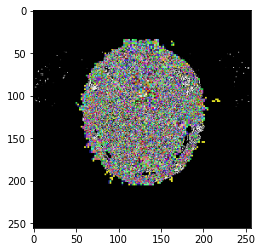

In [15]:
#--------------------------------
f = Image_fusion_tool('output')
#fused_image = f.pyramid_image_fusion(im0, im1, 'weighted')
#fused_image = f.weighted_average_fusion(im0,im1,0.7,0.3)
#fused_image = f.HSI_image_fusion(images[0],images[1]) # solo per immagini a colori
#fused_image = f.PCA_image_fusion(im0, im1)
fused_image = f.PCA_fusion(im0, im1)

fused_img = np.clip(fused_image, 0, 1)
fused_image =(fused_image * 255).astype(np.uint8)
#----------------------------------

plt.imshow(fused_image, cmap='gray')
plt.imshow(fused_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


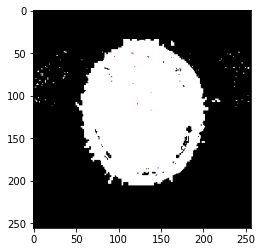

In [16]:
f = Image_fusion_tool('output')
#fused_image = f.pyramid_image_fusion(im0, im1, 'weighted')
fused_image = f.weighted_average_fusion(im0,im1,0.7,0.3)
#fused_image = f.HSI_image_fusion(images[0],images[1]) 
#fused_image = f.PCA_image_fusion(im0, im1)
#fused_image = f.PCA_fusion(im0, im1)

# fused_img = np.clip(fused_image, 0, 1)
# fused_image =(fused_image * 255).astype(np.uint8)
#----------------------------------

plt.imshow(fused_image, cmap='gray')
plt.imshow(fused_image)


C:\Users\hai\Downloads\Telegram Desktop\New folder\pyFusion\legacy\basic_cv_tool.py:64: RuntimeWarning: invalid value encountered in true_divide
  thetha = np.arccos(0.5*(R[i]-B[i]+R[i]-G[i])/den)
C:\Users\hai\Downloads\Telegram Desktop\New folder\pyFusion\legacy\basic_cv_tool.py:76: RuntimeWarning: invalid value encountered in true_divide
  S[i] = 1 - min*3/(R[i]+B[i]+G[i])


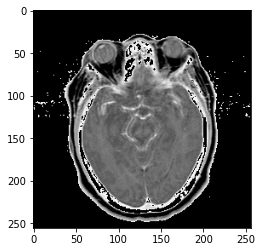

In [17]:
f = Image_fusion_tool('output')
#fused_image = f.pyramid_image_fusion(im0, im1, 'weighted')
#fused_image = f.weighted_average_fusion(im0,im1,0.7,0.3)
fused_image = f.HSI_image_fusion(input_images[0],input_images[1]) 
#fused_image = f.PCA_image_fusion(im0, im1)
#fused_image = f.PCA_fusion(im0, im1)

fused_img = np.clip(fused_image, 0, 1)
fused_image =(fused_image * 255).astype(np.uint8)
#----------------------------------

plt.imshow(fused_image, cmap='gray')
plt.imshow(fused_image)
# imwrite(output+'<nome>.jpg', fused_image)

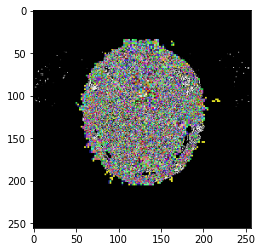

In [18]:
f = Image_fusion_tool('output')
#fused_image = f.pyramid_image_fusion(im0, im1, 'weighted')
#fused_image = f.weighted_average_fusion(im0,im1,0.7,0.3)
#fused_image = f.HSI_image_fusion(images[0],images[1]) 
#fused_image = f.PCA_image_fusion(im0, im1)
fused_image = f.PCA_fusion(im0, im1)

fused_img = np.clip(fused_image, 0, 1)
fused_image =(fused_image * 255).astype(np.uint8)
#----------------------------------

plt.imshow(fused_image, cmap='gray')
plt.imshow(fused_image)
# imwrite(output+'<nome>.jpg', fused_image)

In [19]:
xp.InformationPreservation(im0, im1, fused_image).calculate()

array([0.48959133, 0.47577792, 0.48363024], dtype=float32)

In [20]:
xp.TotalFusionGain(im0, im1, fused_image).calculate()

array([0.34130654, 0.35461405, 0.35285965], dtype=float32)

In [21]:
xp.FusionLossArtifact(im0, im1, fused_image).calculate()

(array([0.30825853, 0.30817425, 0.31486636], dtype=float32),
 array([0.00269857, 0.00317899, 0.00314759], dtype=float32))

In [22]:
mse0 = metrics.mean_squared_error(im0, fused_image) 
mse1 = metrics.mean_squared_error(im1, fused_image) 
mean_mse = (mse0 + mse1) / 2
mean_mse  

3841.147946675618

In [23]:
en0 = metrics.entropy_2d(im0, fused_image)
en1 = metrics.entropy_2d(im1, fused_image)
mean_entropy = (en0 + en1) / 2
mean_entropy

3.0010831627379213

In [24]:
mi0 = metrics.mutual_information_2d(im0, fused_image)
mi1 = metrics.mutual_information_2d(im1, fused_image)
mean_mi = (mi0 + mi1) / 2
mi0

1.1453310263978125

In [25]:
ssim0 = metrics.ssim(im0, fused_image, True)
ssim1 = metrics.ssim(im1, fused_image, True)
mean_ssim = (ssim0 + ssim1) / 2
mean_ssim

0.6313667314788207